# Introduction

We examine the topology of business signs along Kloof Street in Cape Town. The first section examines the signage topology by identifying the establishments with the most or largest signs by area, or the have the tallest or widest signs, and finally their spread along the arterial. We conclude the tutorial with a descriptive statistic analysis. 

The data is multivariate, containing continous and categorical variables, and are measured in different units. _Width_ and _Height_ are measured in metres, while _Area_ is measured in metres-sqaured. The signs' geodetic vertical and horizontal location relative to the prime meridian at Greenwich, and naught at the equator, is measured in _latitude_ and _longitude_ decimal degrees, respectively. Signs are classified as either projecting, boundary wall, flat, or canopy. These are then further classified whether they are illuminatable.

# Development Environment

In [1]:
# Matrix / Frame Configuration
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Plots
import plotly.express as px
import kaleido
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import math

# Spatial Mapping
import folium # spatial heatmap

# Data

In [47]:
filename = '/data/signage2015_kloof_street.csv'
df = pd.read_csv(filename)
df.head()

,Sign,Illuminated,Height,Width,Area,Longitude,Latitude,BusinessSh
0,flatsgn,Yes,20.0,15.0,300.00,18.413518,-33.927335,McDonalds
1,flatsgn,Yes,1.0,1.0,1.00,18.413378,-33.927435,McDonalds
2,flatsgn,Yes,15.0,10.0,150.00,18.413138,-33.927596,McDonalds
3,flatsgn,Yes,0.3,4.0,1.20,18.412546,-33.928151,Dark Paradise
4,flatsgn,No,0.5,1.5,0.75,18.412608,-33.928158,Indie


# 1. Exploratory Data Analysis

## 1.1 Signage Typology

### Signage proportion by Illuminance

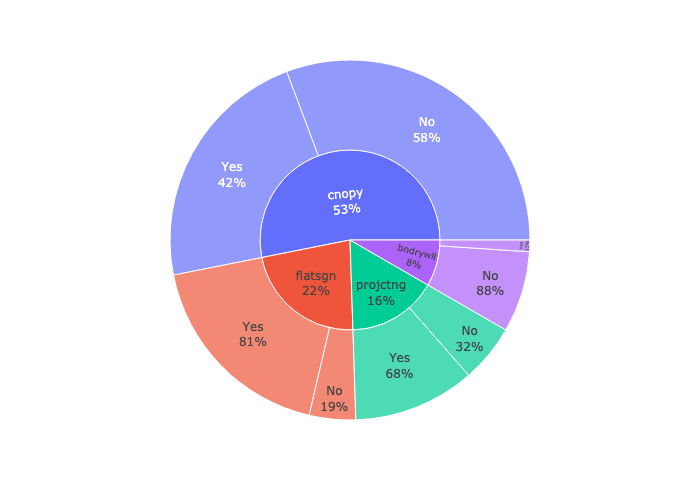

In [49]:
# Sign Typology
fig = px.sunburst(df, path=['Sign', 'Illuminated'])
fig.update_traces(textinfo="label+percent parent")                  
fig.show("png")
#fig.write_image('images/fig1.png')

Signs are classified in four groups, namely:
* Canopy (cnopy)
* Flat Sign (flatsgn)
* Projecting (projectng)
* Boundary Wall (bdrywl)

Ranked by their popularity, the signs are: canopy (at 102 signs); flat signs (at 42 signs); projecting signs (at 31 signs); and boundary wall signs (at 16 signs). While canopy signs make up the largest proportion of signs, most boundary wall signs are illumninated—that is, 88% of the boundary wall sign proportion are illuminated, followed by flat signs at 81%, projecting signs at 68%, and canopy signs at at a mere 42%.

### Top 10 businesses by total signs

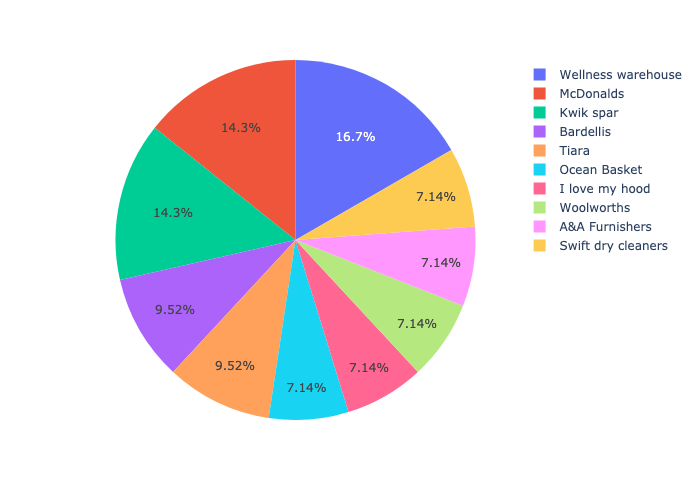

In [50]:
# Top 10 businesses by signage count
top10SignCount = df.groupby('BusinessSh')['Sign'].count().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(top10SignCount, values='Sign', names='BusinessSh')
fig.show("png")
#fig.write_image('images/fig2.png')

Establishments with the most signs are shown in the pie chart above. The Wellness warehouse has 7 signs, followed by McDonalds and Kwikspar, each at 6 signs, Bardellis at 4 signs, and so on. Assuming that international brands has a greater marketing spend, the Wellness Warehouse, a local establishments, exceeds the McDonalds' sign count, an international franchise.

### Top 10 businesses by total signage area (on average)

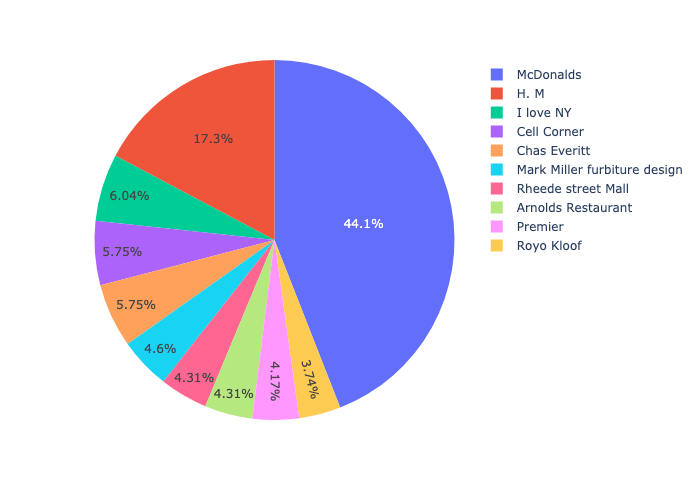

In [38]:
# Top 10 businesses by signage area
top10SignArea = df.groupby('BusinessSh')['Area'].mean().sort_values(ascending=False).reset_index()[:10]
fig = px.pie(top10SignArea, values='Area', names='BusinessSh')
fig.show("png")
#fig.write_image('images/fig3.png')

Just as the total signs be a marketing measure, so are the signage area. In contrast to the sign-count ranking above, McDonalds, followed by H&M, each which are international brands, has the largest signs, at 44.1% and 17.3% respectively of the total-top-ten signage area).

### Top 10 businesses with the tallest signs (on average)

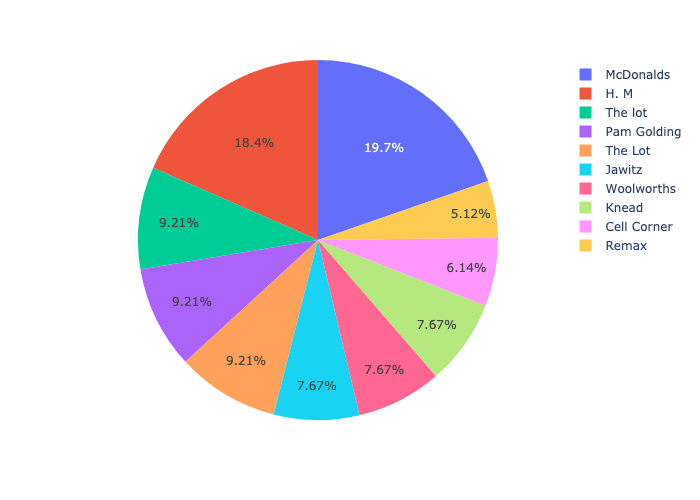

In [39]:
# Top 10 businesses by mean height, i.e., on average businesses with tallest signs
Top10TallestSign = df.groupby('BusinessSh')['Height'].mean().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(Top10TallestSign, values='Height', names='BusinessSh')
fig.show("png")
#fig.write_image('images/fig4.png')

### Top 10 businesses with the widest signs (on average)

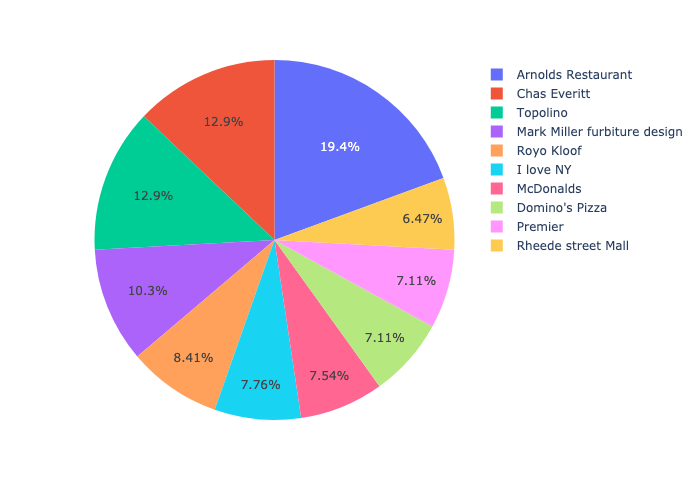

In [52]:
# Top 10 businesses by mean width, i.e., on avg businesses with widest signs
Top10WidestSign = df.groupby('BusinessSh')['Width'].mean().sort_values(ascending=False).reset_index()[:10]

fig = px.pie(Top10WidestSign, values='Width', names='BusinessSh')
fig.show("png")
#fig.write_image('images/fig5.png')

Mean width compared to total width reveals a change in ranking. Arnolds on average has the widest sign (i.e., width = 15m & height = 0.5m)

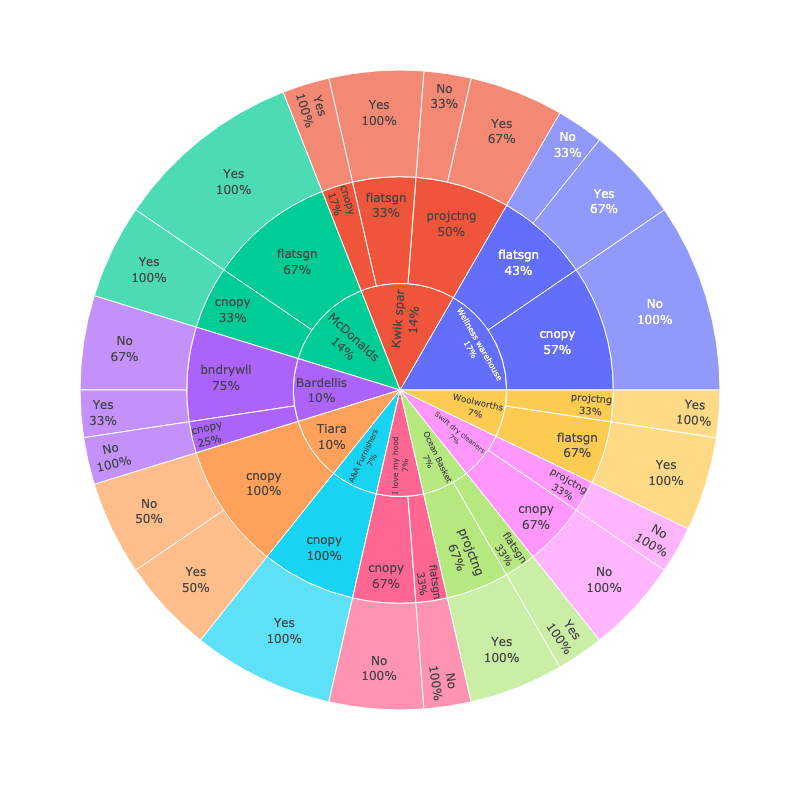

In [53]:
def filterOut(frameToFilter, attributeName, frameToIterate):
    strng = '{} in ['.format(attributeName)
    check = frameToIterate.shape[0]- 1
    for i, row in frameToIterate.iterrows():
        val = row[attributeName]
        if i < check:
            strng += '"{}", '.format(val)
        else:
            strng += '"{}"]'.format(val)
    #print(strng)
    return frameToFilter.query(strng).sort_values('BusinessSh', ascending=True).reset_index()


fig = px.sunburst(filterOut(df, 'BusinessSh', top10SignCount), 
                  path=['BusinessSh', 'Sign', 'Illuminated'])
fig.update_traces(textinfo="label+percent parent")                  
fig.show("png", width=800, height=800)
#fig.write_image('images/fig6.png',width=800, height=800)

## 1.2 Spatial Distribution

The heatmaps below show signage hotspots occur between Kotze- and Malan Street, Camp- and Union Streen, and finally Kloof- and Orange Street. Apart from Rheede Street with 12 sign locations, intersections collate signage short off Kloof Street and thus reflect comporably greater concentration. 

In [68]:
# Function for generating a base map
# REF: https://geopandas.org/en/stable/gallery/plotting_with_folium.html
def generateBaseMap(default_location = [-33.929, 18.411], default_zoom_start=100):
    basemap = folium.Map(location=default_location, tiles='Stamen Toner', zoom_start=default_zoom_start)
    return basemap

# Create base map by calling generatebasemap() function
basemap = generateBaseMap()

# Add points to the map
from folium.plugins import HeatMap
HeatMap(df[['Latitude', 'Longitude']], max_zoom=100).add_to(basemap)

# Display Map
basemap

In [56]:
from folium import Marker
from folium.plugins import MarkerCluster
mc = MarkerCluster()
for idx, row in df.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']],
                            popup =
                            "Type: " + str(row['Sign']) + '<br>' +
                            "Lat: " + str(row['Latitude']) + '<br>' +
                            "Long: " + str(row['Longitude']) + '<br>'
                            "Area: " + str(row['Area']) + '<br>' +
                            "Business: " + str(row['BusinessSh'])))       
basemap.add_child(mc)

In [70]:
mapSignSize = generateBaseMap()

def color_producer(val):
    if val > 0 and val <= 2:
        return 'mediumblue'
    elif val > 2 and val <= 8:
        return 'red'
    elif val > 8 and val <= 10:
        return 'cyan'
    else:
        return 'magenta'

from folium import Circle

for idx, row in df.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        Circle(radius=5,
               location=[row['Latitude'], row['Longitude']],
               color=color_producer(row['Area']),
               popup=
               'Type: ' + str(row['Sign']) + '<br>' +
               'Lat: ' + str(row['Latitude']) + '<br>' +
               'Long: ' + str(row['Longitude']) + '<br>' +
               'Area: ' + str(row['Area']) + '<br>' + 
               'Business: ' + str(row['BusinessSh'])).add_to(mapSignSize)

# Display the map
mapSignSize

By way of the magenta coloured circles, the largest signs occur at the start and end of Kloof Street. Most signs are below 2$m^2$, followed by those between 2$m^2$ and 8$m^2$, dotted along the arterial.

# 2. Descriptive Data Analysis

In [59]:
# Calculate the logDimension and append frame with logValue
def calcLog(dimension): 
    var = 'log'+ dimension
    if var in df.columns: # Check if column exist in df
        return var
    else:
        df[var] = np.log(df[dimension]+1)
        return var

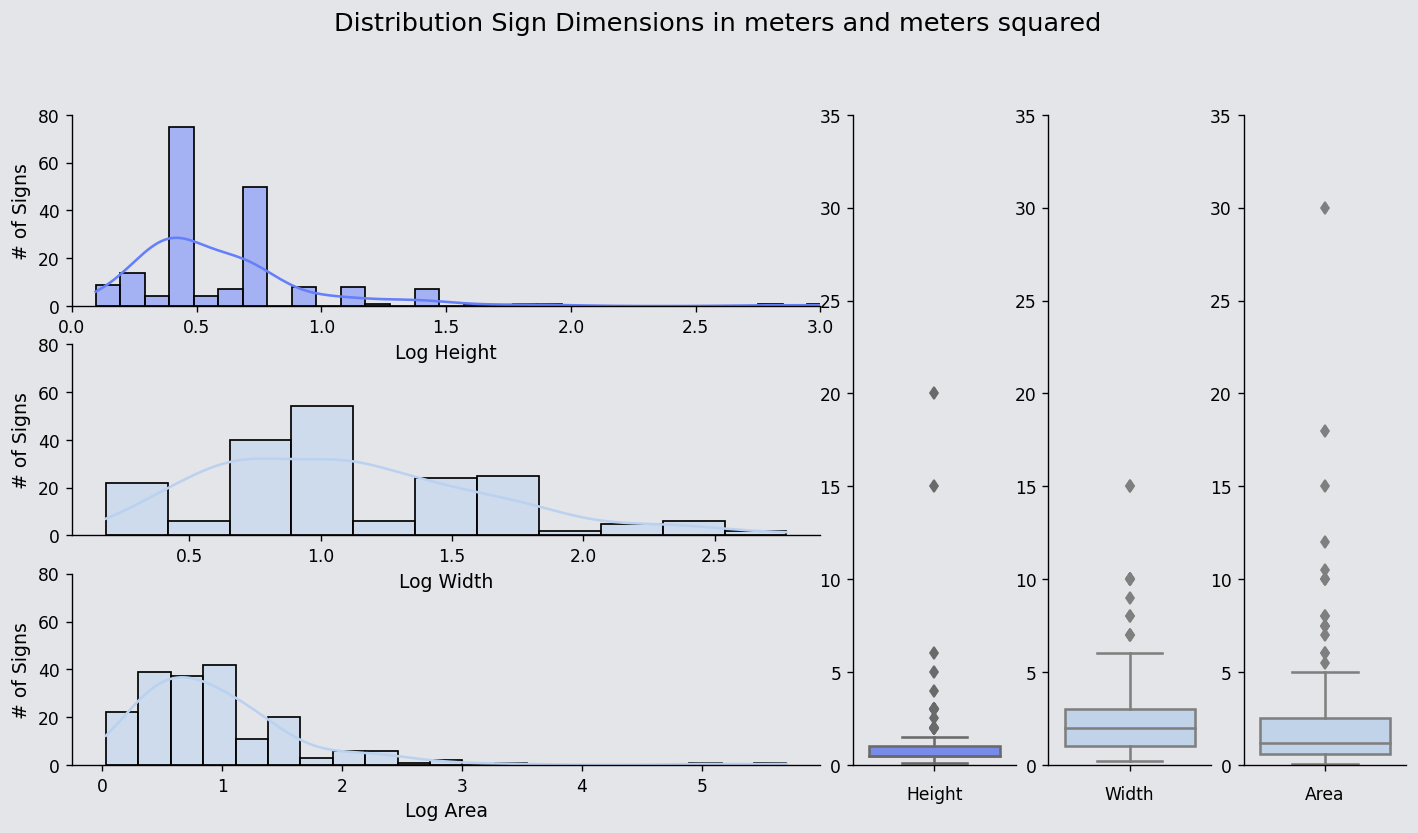

In [60]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=7, nrows=3)

# Configure Distribution Plots
g0 = fig.add_subplot(spec[0, :4])
sns.histplot(df[calcLog('Height')], kde=True, color='#657FFB', edgecolor='black') #kde - kernal density estimate
# sns.histplot(x='Height', data=df, kde=True, color='#657FFB', edgecolor='black') 
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Height', fontsize=11)
plt.xlim(0, 3)
plt.ylim(0, 80)

g1 = fig.add_subplot(spec[1, :4])
sns.histplot(df[calcLog('Width')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Width', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Width', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

g2 = fig.add_subplot(spec[2, :4])
sns.histplot(df[calcLog('Area')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Width', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Area', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

# Configure Box Plots
g3 = fig.add_subplot(spec[:, 4])
sns.boxplot(y=df['Height'], color='#657FFB')
plt.xlabel('Height', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g4 = fig.add_subplot(spec[:, 5])
sns.boxplot(y=df['Width'], color='#BAD2EF')
plt.xlabel('Width', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g5 = fig.add_subplot(spec[:, 6])
sns.boxplot(y=df['Area'], color='#BAD2EF')
plt.xlabel('Area', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

for g in [g0, g1, g2, g3, g4, g5]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('Distribution Sign Dimensions in meters and meters squared', fontsize=15, y=1)
plt.show()

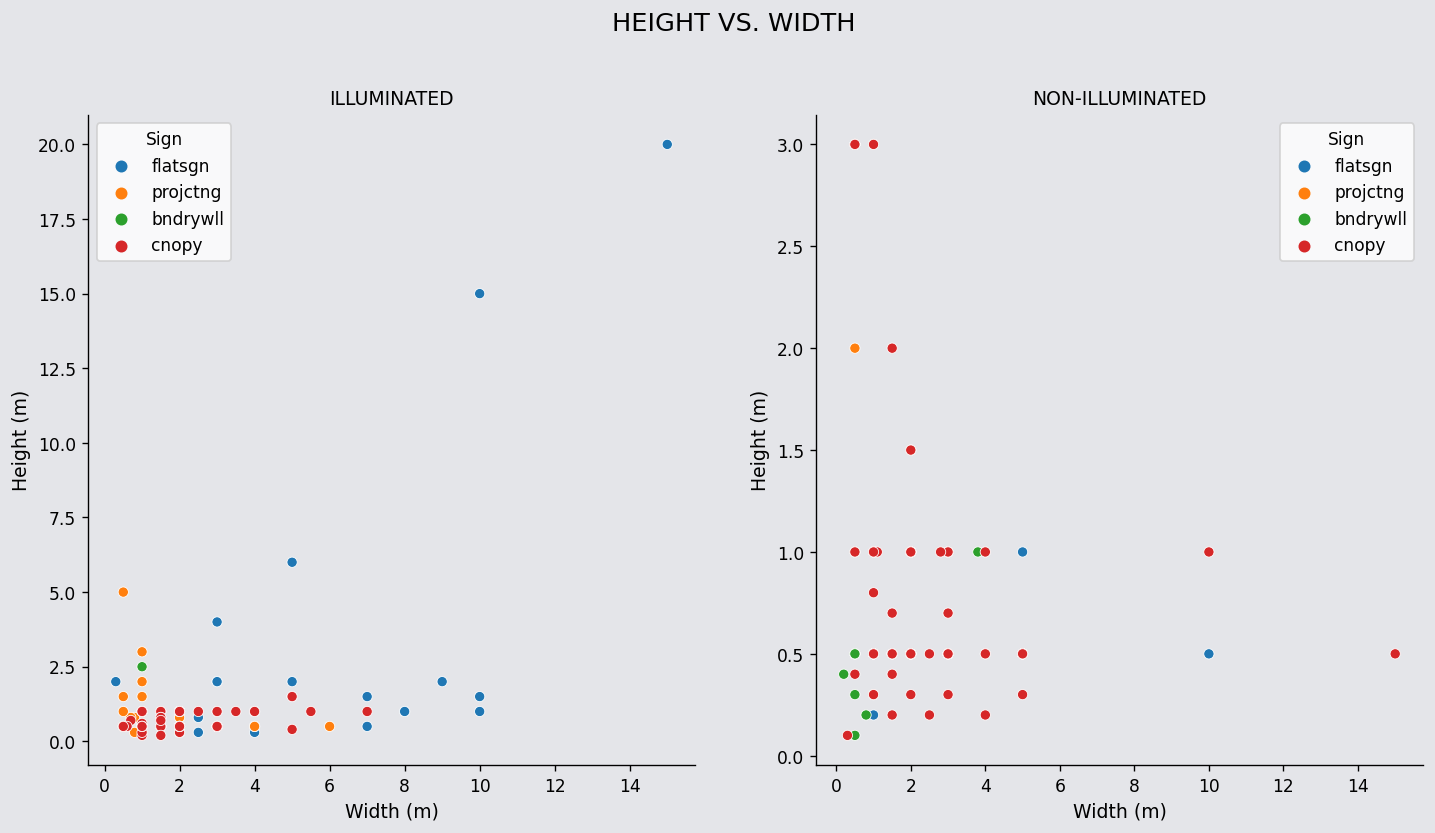

In [61]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=2, nrows=2)

g0 = fig.add_subplot(spec[0:2, :1])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.scatterplot(data=df.loc[df.Illuminated == "Yes"], 
                x='Width', 
                y='Height', 
                hue='Sign')
plt.ylabel('Height (m)', fontsize=11)
plt.xlabel('Width (m)', fontsize=11)
plt.title('ILLUMINATED', fontsize=11)
#plt.xlim(0, 3)
#plt.ylim(0, 80)

g1 = fig.add_subplot(spec[0:2, 1:2])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.scatterplot(data=df.loc[df.Illuminated == "No" ], 
                x='Width', 
                y='Height', 
                hue='Sign')
plt.ylabel('Height (m)', fontsize=11)
plt.xlabel('Width (m)', fontsize=11)
plt.title('NON-ILLUMINATED', fontsize=11)
#plt.xlim(0, 3)
#plt.ylim(0, 80)

for g in [g0, g1]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('HEIGHT VS. WIDTH', fontsize=15, y=1)
plt.show()

## 2.1 Check for Normality

The above plots reveal that the data is non-normaly distributed. Below we confirm this by use of the probability plot and the several best fit tests. The code for the best fit test is taken from Haslwanter (2016), noting that for intermediate sample sizes, the Lilliefors-test is recommended (Haslwanter, 2016). 

### 2.1.1 Best Fit Tests

<ipython-input-63-fad2d9a3e250>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-63-fad2d9a3e250>:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



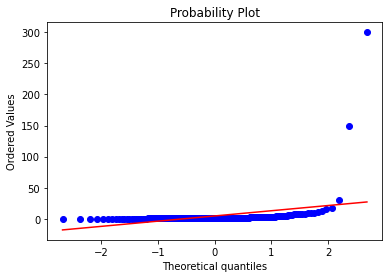

BEST FIT TESTS FOR NORMALITY:

p-values for all 192 data points: ----------------
Omnibus               5.805881e-82
Shapiro-Wilk          6.553585e-29
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    3.918015e-32
dtype: float64

p-values for the first 96 data points: ----------------
Omnibus               1.352140e-39
Shapiro-Wilk          1.241750e-20
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    2.030115e-15
dtype: float64

The Area is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):
0.0009999999999998899


In [63]:
# REF: https://github.com/thomas-haslwanter/statsintro_python/blob/master/ISP/Code_Quantlets/07_CheckNormality_CalcSamplesize/checkNormality/ISP_checkNormality.py

from statsmodels.stats.diagnostic import lilliefors

def check_normality(data, name):
    # Holder for test results
    pVals = pd.Series()
    pFewVals = pd.Series()
    
    #Portion out half of the dataset
    fewVal = 96 #len(data)
    fewData = data[:fewVal]

    # Normal Distribution
    #sns.distplot(data, fit=norm);
    #fig = plt.figure()
    
    # GRAPHICAL TEST: PROBABILITY PLOT
    _ = stats.probplot(data, plot=plt)
    plt.show()

    # OMNIBUS TEST
    # Scipy normality test is based on the D-Agostino and Pearsons test that
    # combines skey and kurtosis to produce an Omnibus Test of normality
    _, pVals['Omnibus'] = stats.normaltest(data)
    _, pFewVals['Omnibus'] = stats.normaltest(fewData)

    # SHAPIRO-WILK TEST
    _, pVals['Shapiro-Wilk'] = stats.shapiro(data)
    _, pFewVals['Shapiro-Wilk'] = stats.shapiro(fewData)

    # LILLIEFORS TEST
    _, pVals['Lilliefors'] = lilliefors(data)
    _, pFewVals['Lilliefors'] = lilliefors(fewData)

    # KOLMOGOROV-SMIRNOV TEST (not for sample sizes < 300)
    _, pVals['Kolmogorov-Smirnov'] = stats.kstest((data-np.mean(data))/np.std(data, ddof=1), 'norm')
    _, pFewVals['Kolmogorov-Smirnov'] = stats.kstest((fewData-np.mean(fewData))/np.std(fewData, ddof=1), 'norm')
    
    #Print results
    print('BEST FIT TESTS FOR NORMALITY:\n')
    print('p-values for all {0} data points: ----------------'.format(len(data)))
    print(pVals)
    
    print('\np-values for the first {0} data points: ----------------'.format(fewVal))
    print(pFewVals)
    
    if pVals['Lilliefors'] > 0.05:
        print('\nData is normally distributed')
    else:
        print('\nThe ' +name+ ' is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):')
    # --- >>> STOP stats <<< ---
    
    return pVals['Lilliefors']
    

if __name__ == '__main__':
    p = check_normality(df['Area'], 'Area')   
    print(p)


The test above show that the Area is non-normally distributed. The probability plot reveals several outliers, however, these outsized signs are confirmed not to be a measurement error. Next we investigate the effect on normality by removing the outliers.

In [64]:
# Sort Data in Descending Order By Area
df.sort_values(by = 'Area', ascending=False)[:10]

,Sign,Illuminated,Height,Width,Area,Longitude,Latitude,BusinessSh,logHeight,logWidth,logArea
0,flatsgn,Yes,20.0,15.0,300.0,18.413518,-33.927335,McDonalds,3.044522,2.772589,5.707110
2,flatsgn,Yes,15.0,10.0,150.0,18.413138,-33.927596,McDonalds,2.772589,2.397895,5.017280
30,flatsgn,Yes,6.0,5.0,30.0,18.413364,-33.926971,H. M,1.945910,1.791759,3.433987
9,flatsgn,Yes,2.0,9.0,18.0,18.411716,-33.929014,I love NY,1.098612,2.302585,2.944439
22,flatsgn,Yes,1.5,10.0,15.0,18.411125,-33.929735,Wellness warehouse,0.916291,2.397895,2.772589
15,flatsgn,Yes,4.0,3.0,12.0,18.411410,-33.929237,Knead,1.609438,1.386294,2.564949
35,flatsgn,Yes,1.5,7.0,10.5,18.406855,-33.934874,Premier,0.916291,2.079442,2.442347
32,flatsgn,Yes,1.0,10.0,10.0,18.408825,-33.932134,Royo Kloof,0.693147,2.397895,2.397895
7,flatsgn,Yes,2.0,5.0,10.0,18.411799,-33.928915,Cell Corner,1.098612,1.791759,2.397895
145,cnopy,No,1.0,10.0,10.0,18.409074,-33.932206,Chas Everitt,0.693147,2.397895,2.397895


In [65]:
# Remove outliers i.e., Areas >= 10.5
df_outlier_removed = df.loc[df.Area < 10.5]
df_outlier_removed.sort_values(by='Area', ascending=False)[:10]

,Sign,Illuminated,Height,Width,Area,Longitude,Latitude,BusinessSh,logHeight,logWidth,logArea
32,flatsgn,Yes,1.0,10.0,10.0,18.408825,-33.932134,Royo Kloof,0.693147,2.397895,2.397895
7,flatsgn,Yes,2.0,5.0,10.0,18.411799,-33.928915,Cell Corner,1.098612,1.791759,2.397895
145,cnopy,No,1.0,10.0,10.0,18.409074,-33.932206,Chas Everitt,0.693147,2.397895,2.397895
42,flatsgn,Yes,1.0,8.0,8.0,18.407308,-33.934152,Mark Miller furbiture design,0.693147,2.197225,2.197225
25,flatsgn,Yes,1.0,8.0,8.0,18.412404,-33.928190,Kwik spar,0.693147,2.197225,2.197225
5,flatsgn,Yes,1.5,5.0,7.5,18.412447,-33.929366,Rheede street Mall,0.916291,1.791759,2.140066
175,cnopy,No,0.5,15.0,7.5,18.409706,-33.930791,Arnolds Restaurant,0.405465,2.772589,2.140066
107,cnopy,Yes,1.5,5.0,7.5,18.412326,-33.929308,Sawaddee,0.916291,1.791759,2.140066
92,cnopy,Yes,1.0,7.0,7.0,18.413566,-33.927349,McDonalds,0.693147,2.079442,2.079442
17,flatsgn,Yes,2.0,3.0,6.0,18.411382,-33.929185,Woolworths,1.098612,1.386294,1.945910


<ipython-input-63-fad2d9a3e250>:7: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

<ipython-input-63-fad2d9a3e250>:8: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



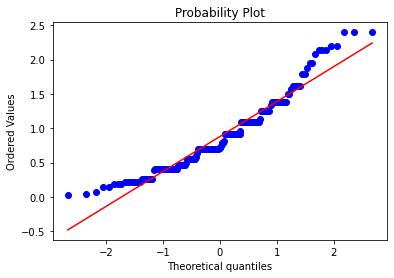

BEST FIT TESTS FOR NORMALITY:

p-values for all 185 data points: ----------------
Omnibus               2.922019e-05
Shapiro-Wilk          3.596243e-07
Lilliefors            1.000000e-03
Kolmogorov-Smirnov    2.572961e-03
dtype: float64

p-values for the first 96 data points: ----------------
Omnibus               0.007709
Shapiro-Wilk          0.000078
Lilliefors            0.001000
Kolmogorov-Smirnov    0.005294
dtype: float64

The Area is non-normally distributed, i.e., it reflects a statistically significant difference (p < 0.05):
0.0009999999999998899


In [66]:
# Check whether the removal of outliers has made improvement on the data's normality.
print(check_normality(df_outlier_removed[calcLog('Area')], 'Area'))

After removing the extreme outliers the data still reflects a non-normal distribution.

## 2.2 Tests for Categorical Data (i.e., Non Parametric Tests)

Since the categorical data is non-interval, test for normality is not necessary (Anwar 2021; Wallis 2021). The categorical variables in question are those identified earlier in section 1.1—i.e., the type of signs.

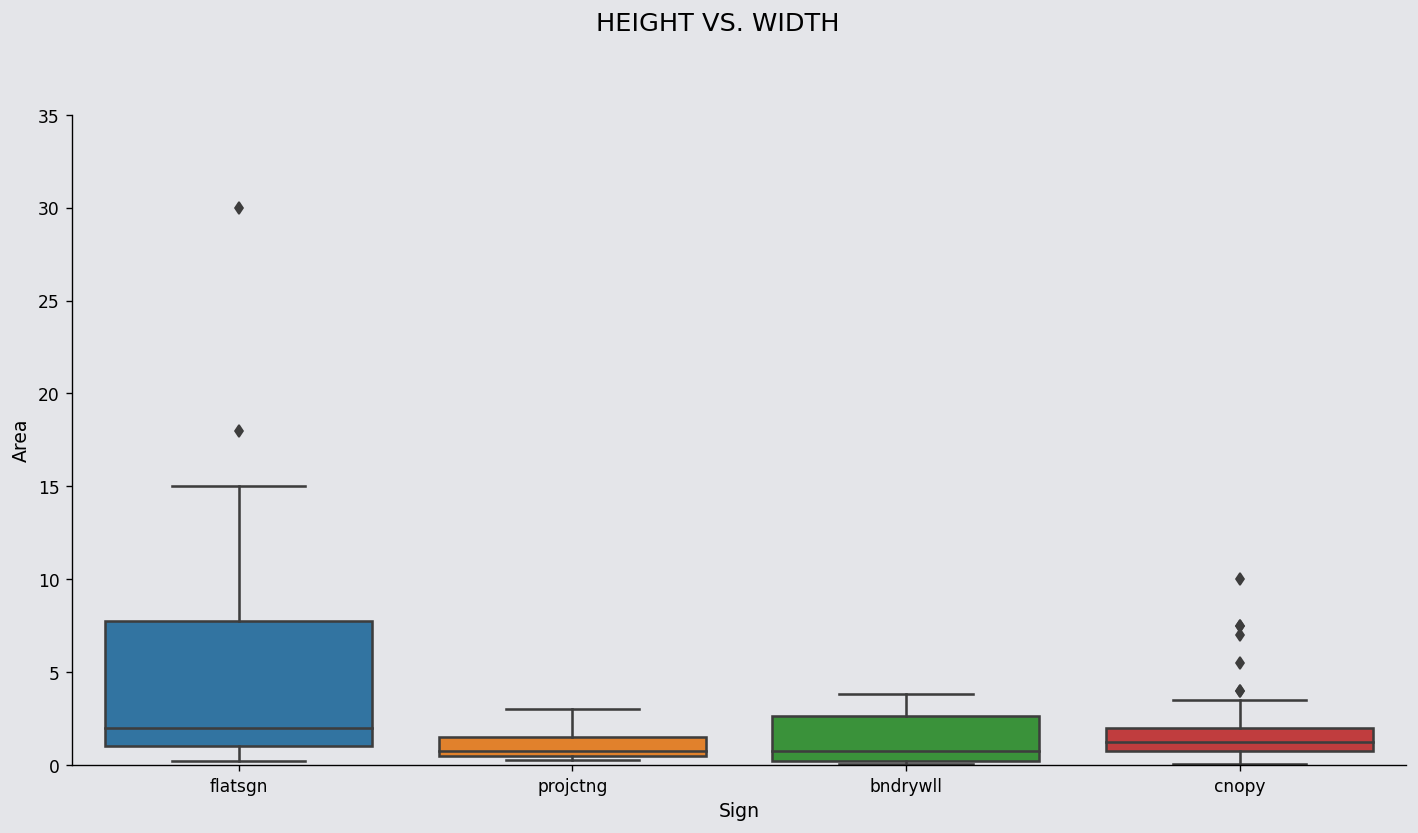

In [67]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=1, nrows=2)

g0 = fig.add_subplot(spec[0:2, :1])
# Calculate Dimensional Ratios
#height_rate = dfStats.eval("Height / Area").rename("height_rate")
sns.boxplot(data=df, 
                x='Sign', 
                y='Area')
plt.ylabel('Area', fontsize=11)
plt.xlabel('Sign', fontsize=11)
#plt.xlim(0, 3)
plt.ylim(0, 35)

for g in [g0]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('HEIGHT VS. WIDTH', fontsize=15, y=1)
plt.show()

# References

Haslwanter, T. (2016). An Introduction to Statistics with Python. 

Wallis, Jamie. (2021). Re: Normality test for categorical variables?. Retrieved from: https://www.researchgate.net/post/Normality_test_for_categorical_variables/60c45303e006b91214360cf7/citation/download. 

Anwar, Imran. (2021). Re: Normality test for categorical variables?. Retrieved from: https://www.researchgate.net/post/Normality_test_for_categorical_variables/60c45a2d04fe610c7216412b/citation/download. 